In [1]:
pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image

from utils import *

# L63 Data simulation

Training dataset: 10000x3x200
Test dataset    : 2000x3x200


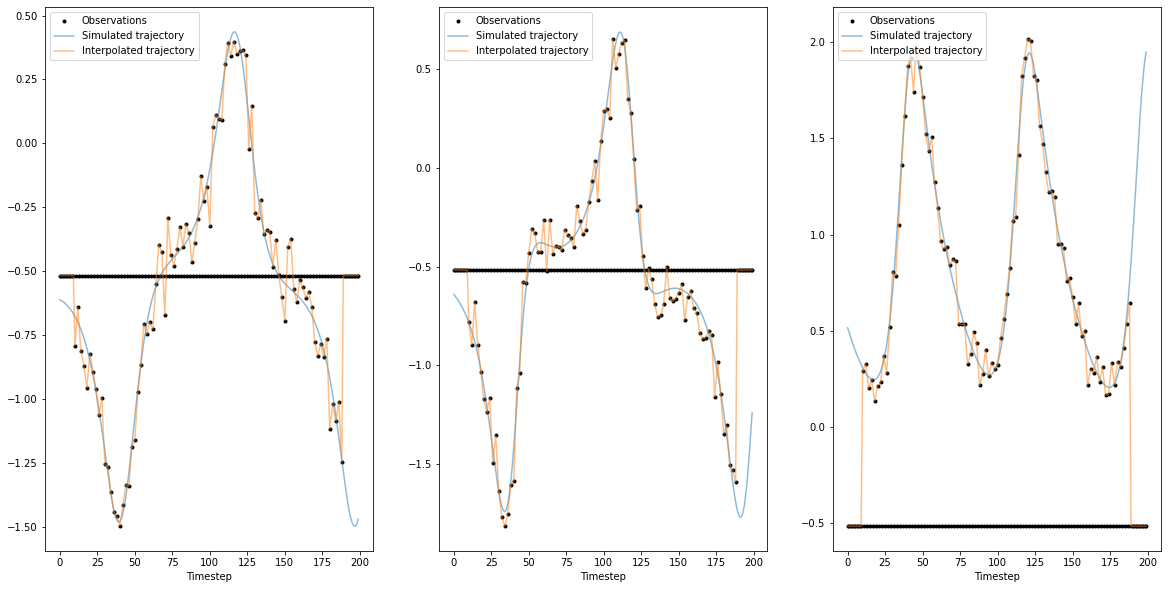

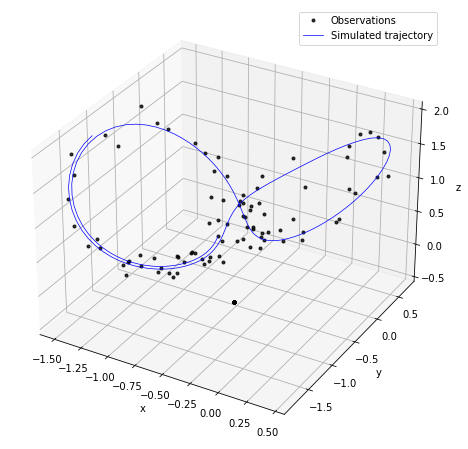

In [3]:
## data generation: L63 series
SD = Simulation_data()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(SD.dt_integration,SD.nb_loop_test*SD.dt_integration+0.000001,SD.dt_integration)
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=np.arange(0,5+0.000001,SD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[SD.dt_integration,SD.nb_loop_test+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()
  
xt = time_series()
xt.values = S
xt.time   = tt

#Data Extraction
x_train, x_val, x_test, x_train_obs, x_val_obs,x_test_obs, x_train_missing, x_val_missing,x_test_missing, mask_train,mask_val, mask_test,x_train_Init,x_val_Init, x_test_Init, meanTr, stdTr =  L63PatchDataExtraction(xt=xt,RMD=0.5)

print('Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

#Data Visualisation
visualisation_data(x_train,x_train_obs,x_train_Init,180)

# CNN architecture

In [4]:
shapeData  = x_train.shape[1:]
dW = 1
dimCNN = 10
class CNN(pl.LightningModule):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1  = torch.nn.Conv1d(shapeData[0],shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv2  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv3  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv4  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv5  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv6  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,1,padding=0,bias=False)
        self.conv7  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0],1,padding=0,bias=False)

        self.tot_loss=[]
        self.tot_val_loss=[]
        
        self.best_loss=1e10
        
    def forward(self,xinp):
        
        x = self.conv1( xinp )
        x = self.conv2( F.relu(x) )
        x = self.conv3( F.relu(x) )
        #x = self.conv4( F.relu(x) )
        #x = self.conv5( F.relu(x) )
        #x = self.conv6( F.relu(x) )
        x = self.conv7( F.relu(x) )
        x = x.view(-1,shapeData[0],shapeData[1])

        return x
    def setup(self,stage='None'):
        batch_size=128
        training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) 
        val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(x_val_Init),torch.Tensor(x_val_obs),torch.Tensor(mask_val),torch.Tensor(x_val)) 
        test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) 
        self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

        
    def loss(self, x, y):
         return torch.mean((x - y)**2 )
    
    def training_step(self, train_batch, batch_idx):
        running_loss = 0.0
        num_loss     = 0
        
        inputs_init,inputs_missing,masks,targets_GT  = train_batch
        inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
        #retain_graph=True
        #outputs = model_CNN(inputs_missing)
        #loss      = torch.mean((outputs - targets_GT)**2 )
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        epoch_loss       = running_loss / num_loss
        self.tot_loss.append(loss)
        
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs_init,inputs_missing,masks,targets_GT  = val_batch
        running_val_loss = 0.0
        num_val_loss     = 0

        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
           
        running_val_loss             += loss.item() * inputs_missing.size(0)
        num_val_loss                 += inputs_missing.size(0)
        epoch_val_loss       = running_val_loss / num_val_loss
        self.tot_val_loss.append(loss)
        self.log('val_loss', loss ,prog_bar=False,logger=False)
        if  epoch_val_loss < self.best_loss:
            self.best_loss = epoch_val_loss
            self.best_model_wts = copy.deepcopy(model_CNN.state_dict())

        return loss

    def configure_optimizers(self):
        self.optimizer      = optim.Adam(model_CNN.parameters(), lr=1e-4)
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.1)

        return self.optimizer
    
    def train_dataloader(self):
        return self.dataloaders['train']
    
    def val_dataloader(self):
        return self.dataloaders['val']
    
    def test_dataloader(self):
        return self.dataloaders['test']

In [5]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=50,enable_progress_bar=True)
trainer.fit(model_CNN)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


CNN(
  (conv1): Conv1d(3, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv7): Conv1d(30, 3, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 5760



  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 270   
1 | conv2 | Conv1d | 2.7 K 
2 | conv3 | Conv1d | 2.7 K 
3 | conv7 | Conv1d | 90    
---------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  83%|█████████▉  | 79/95 [00:03<00:00, 21.81it/s, loss=0.511, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|█████████▉  | 79/95 [00:03<00:00, 22.46it/s, loss=0.174, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|█████████▏ | 79/95 [00:03<00:00, 22.08it/s, loss=0.0794, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|█████████▉  | 79/95 [00:03<00:00, 22.09it/s, loss=0.056, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|█████████▉  | 79/95 [00:03<00:00, 21.85it/s, loss=0.048, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|█████████▏ | 79/95 [00:03<00:00, 22.06it/s, loss=0.0429, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|█████████▏ | 79/95 [00:03<00:00, 22.22it/s, loss=0.0385, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|█████████▏ | 79/95 [00:03<00:00, 22.27it/s, loss=0.0369, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|█████████▏ | 79/95 [00:03<00:00, 22.10it/s, loss=0.0354, v_num=48]
Validating: 0it [00:00,

Epoch 22:  83%|████████▎ | 79/95 [00:03<00:00, 22.46it/s, loss=0.0298, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 23:  83%|████████▎ | 79/95 [00:03<00:00, 22.46it/s, loss=0.0294, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 24:  83%|████████▎ | 79/95 [00:03<00:00, 22.18it/s, loss=0.0288, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 25:  83%|█████████▏ | 79/95 [00:03<00:00, 21.61it/s, loss=0.029, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 26:  83%|█████████▏ | 79/95 [00:03<00:00, 22.25it/s, loss=0.029, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 27:  83%|████████▎ | 79/95 [00:03<00:00, 22.39it/s, loss=0.0287, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 28:  83%|████████▎ | 79/95 [00:03<00:00, 22.41it/s, loss=0.0283, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 29:  83%|████████▎ | 79/95 [00:03<00:00, 21.82it/s, loss=0.0284, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 30:  83%|████████▎ | 79/95 [00:03<00:00, 22.45it/s, loss=0.0283, v_num=48]
Validating: 0it [00:00,

Epoch 44:  83%|████████▎ | 79/95 [00:03<00:00, 22.35it/s, loss=0.0268, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 45:  83%|████████▎ | 79/95 [00:03<00:00, 22.22it/s, loss=0.0269, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 46:  83%|████████▎ | 79/95 [00:03<00:00, 21.85it/s, loss=0.0265, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 47:  83%|████████▎ | 79/95 [00:03<00:00, 21.25it/s, loss=0.0261, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 48:  83%|████████▎ | 79/95 [00:03<00:00, 21.09it/s, loss=0.0256, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 49:  83%|████████▎ | 79/95 [00:03<00:00, 21.63it/s, loss=0.0261, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 95/95 [00:03<00:00, 24.32it/s, loss=0.0261, v_num=48]


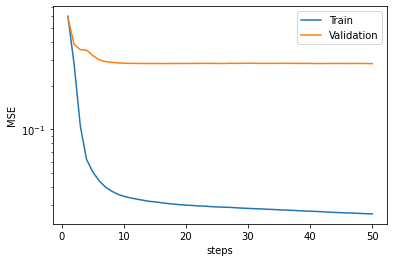

In [6]:
plot_loss(model_CNN,max_epoch=50)

0.75926685


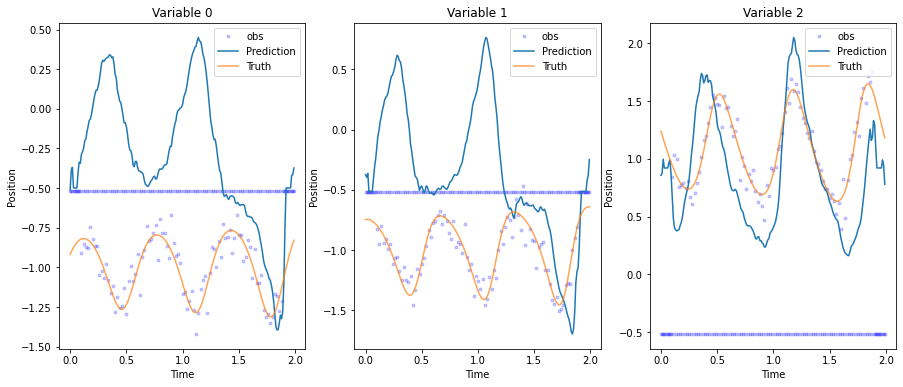

In [11]:
batch_size=128
training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) 
val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(x_val_Init),torch.Tensor(x_val_obs),torch.Tensor(mask_val),torch.Tensor(x_val)) 
test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) 
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

plot_prediction(model_CNN,idx=26,dataset = dataloaders['test'])
r_score = R_score(model_CNN,idx=1,dataset = dataloaders['test'])
print(r_score)

In [ ]:
`